# PROJEKT - PINGWINY 


## 1) Import bilbiotek , pobranie i przygotowanie danych

In [157]:
import pandas as pd

df = pd.read_csv("/Users/../pingwiny.csv", sep=";")
df

,gatunek,wyspa,dlugosc_dzioba_mm,szerokosc_dzioba_mm,dlugosc_pletwy_mm,masa_ciala_g,plec
0,Pingwin bialobrewy (Pygoscelis papua),Biscoe,42,"13,5",210,4150,SAMICA
1,Pingwin bialobrewy (Pygoscelis papua),Biscoe,"46,5","13,5",210,4550,SAMICA
2,Pingwin bialobrewy (Pygoscelis papua),Biscoe,"47,5",14,212,4875,SAMICA
3,Pingwin bialobrewy (Pygoscelis papua),Biscoe,"43,3",14,208,4575,SAMICA
4,Pingwin bialobrewy (Pygoscelis papua),Biscoe,"45,5","14,5",212,4750,SAMICA
...,...,...,...,...,...,...,...
337,Pingwin maskowy (Pygoscelis antarctica),Dream,51,"18,8",203,4100,SAMIEC
338,Pingwin maskowy (Pygoscelis antarctica),Dream,"52,2","18,8",197,3450,SAMIEC
339,Pingwin maskowy (Pygoscelis antarctica),Dream,"52,7","19,8",197,3725,SAMIEC
340,Pingwin maskowy (Pygoscelis antarctica),Dream,"55,8","19,8",207,4000,SAMIEC


In [158]:
#----------- Przeksztalcanie zmiennych

# 1. Zamień na liczby
df["plec"] = df["plec"].replace({"SAMICA": 0, "SAMIEC": 1})

# 2. Wypełnianie braków danych
df["plec"] = df["plec"].fillna(df["plec"].mode()[0])

# 3. Zmiena typ na liczbowy
df["plec"] = df["plec"].astype("int64")
df.dtypes

# zmiana na float64 
cols = ["dlugosc_dzioba_mm", "szerokosc_dzioba_mm"]

df[cols] = (
    df[cols]
    .apply(lambda x: x.str.replace(",", "."))
    .astype(float)
)

/var/folders/qp/9m24hmgj2zj_6c8sjvtnvdww0000gn/T/ipykernel_1530/2791454843.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["plec"] = df["plec"].replace({"SAMICA": 0, "SAMIEC": 1})


In [159]:
# zmiana zmiennych 'wyspa' ' gatunek' na zmienne nominalne 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(drop='first', sparse_output=False) 
gatunek_encoded = encoder.fit_transform(df[['wyspa', 'gatunek']])

encoded_cols = encoder.get_feature_names_out(['wyspa', 'gatunek'])

df_encoded = pd.DataFrame(gatunek_encoded, columns=encoded_cols)

df = pd.concat([df.drop(['wyspa', 'gatunek'], axis=1), df_encoded], axis=1)


## 2) Pierwszy model regresji liniowej


In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

y = df["masa_ciala_g"]
X = df.drop(columns="masa_ciala_g")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## 3) Interpretacja parametrów Beta

In [162]:
print("Beta:", model.coef_, "Intercept:", model.intercept_)

Beta: [  30.43658175   72.81253284   16.19040436  322.66386452  -22.05415102
  -96.14470574  886.45469187 -378.40618771] Intercept: -2026.9617695065554


### y = -2026.96 + 30.44X1 + 72.81X2 + 16.19X3 + 322.66X4 - 22.05X5 - 96.14X6 + 886.45 - 378.41 + e

### INTERPRETACJA WSPOLCZYNNIKOW BETA:

X1 - dlugosc_dzioba_mm: 30.44
Wzrost dlugosci dzioba o 1 mm powoduje wzrost masy ciala o 30.44 grama

X2 - szerokosc_dzioba_mm: 72.81
Wzrost szerokosci dzioba o 1 mm powoduje wzrost masy ciala o 72.81 grama

X3 - dlugosc_pletwy_mm: 16.19
Wzrost dlugosci pletwy o 1 mm powoduje wzrost masy ciala o 16.19 grama

X4 - plec: 322.66
Samce (wartosc 1) sa srednio ciezsze od samic (wartosc 0) o 322.66 grama

X5 - wyspa_Dream: -22.05
Pingwiny z wyspy Dream waza srednio 22.05 grama mniej niz pingwiny z wyspy Biscoe (wyspa referencyjna)

X6 - wyspa_Torgersen: -96.14
Pingwiny z wyspy Torgersen waza srednio 96.14 grama mniej niz pingwiny z wyspy Biscoe

X7 - gatunek_Pingwin bialobrewy: 886.45
Pingwiny bialobrewy waza srednio 886.45 grama wiecej niz pingwiny Adeli (gatunek referencyjny)

X8 - gatunek_Pingwin maskowy: -378.41
Pingwiny maskowe waza srednio 378.41 grama mniej niz pingwiny Adeli

Wyraz wolny: -2026.96
Wartosc teoretyczna masy ciala gdy wszystkie zmienne sa rowne zero - nie ma interpretacji praktycznej


## 4) Interpretacja parametrów modelu

In [136]:
import statsmodels.api as sm

X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y, X_with_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           masa_ciala_g   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     270.4
Date:                Thu, 09 Oct 2025   Prob (F-statistic):          1.11e-140
Time:                        15:08:12   Log-Likelihood:                -2427.3
No. Observations:                 342   AIC:                             4873.
Df Residuals:                     333   BIC:                             4907.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Interpretacja
R^2 = 0.867 - zmienne objaśniające bardzo dobrze wyjaśniają zmienną objaśnianą (masę ciała).

Zmienne X1,X2,X3,X4,X7,X8 sa istotne statystycznie, p-value < 0.05. Nie mamy podstaw do odrzucenia H0 na rzecz H1. 

Zmienne X5, X6 sa nieistotne statystycznie, p-value > 0.05. Zatem odrzucamy H0 na rzecz H1. 

Wartość p-modelu = 1.11e-140  - prawie 0, model jest bardzo istotny statystyczny

## 5) Wykres rozrzutu dla reszt modelu. Test na homogeniczność modelu - Test White'a.

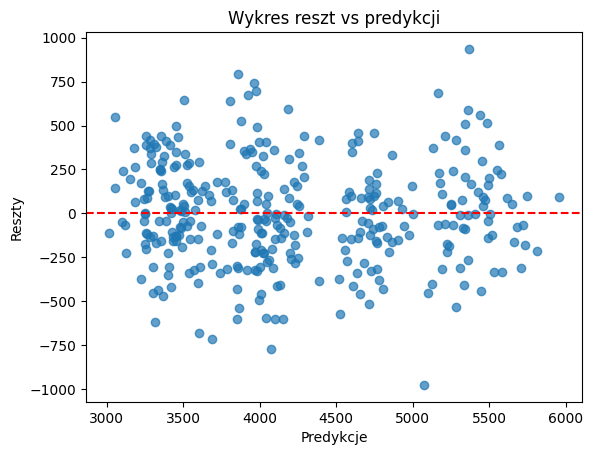

In [163]:
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_white

y_pred_all = model.predict(X)
residuals_all = y - y_pred_all

# Wykres reszt
plt.scatter(y_pred_all, residuals_all, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predykcje')
plt.ylabel('Reszty')
plt.title('Wykres reszt vs predykcji')
plt.show()

In [165]:
# 3. Test White'a
white_test = het_white(residuals_all, X_with_const)
print("TEST WHITE'A:")
print(f"p-value: {white_test[1]:.4f}")

if white_test[1] > 0.05:
    print("Homoskedastyczność")
else:
    print("Heterosk4edastyczność ")

TEST WHITE'A:
p-value: 0.0673
Homoskedastyczność


### Wniosek: Wariancja reszt jest STAŁA - model spełnia założenie homoscedastyczności. Brak problemu z nierównomiernym rozrzutem błędów.

## 6) Predykcja modelu dla przypadku:
pingwin maskowy,
samiec,
długośc dzioba 46 mm,
szerokość 21 mm,
długość płetwy 210 mm.

In [155]:
new_penguin = {
    'dlugosc_dzioba_mm': 46,
    'szerokosc_dzioba_mm': 21, 
    'dlugosc_pletwy_mm': 210,
    'plec': 1,  # samiec
    'wyspa_Dream': 0,
    'wyspa_Torgersen': 0,
    'gatunek_Pingwin bialobrewy (Pygoscelis papua)': 0,
    'gatunek_Pingwin maskowy (Pygoscelis antarctica)': 1
}

new_data = pd.DataFrame([new_penguin])

predicted_weight = model.predict(new_data)[0]

print(f"PREDYKCJA MASY CIAŁA: {predicted_weight:.0f} g")

PREDYKCJA MASY CIAŁA: 4246 g


## 7) Konkurencyjny model - drzewo decyzyjne 

In [154]:
from sklearn.tree import DecisionTreeRegressor

# Drzewo decyzyjne
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)

# Predykcja
y_pred_tree = tree_model.predict(X_test)

# Ocena
r2_tree = r2_score(y_test, y_pred_tree)
print(f"R² drzewa: {r2_tree:.4f}")

if r2_tree >= 0.75:
    print(" Warunek spełniony: R² >= 0.75")
else:
    print(" Warunek nie spełniony")

# Predykcja drzewa
weight_tree = tree_model.predict(new_data)[0]
print(f"Predykcja drzewa decyzyjnego: {weight_tree} g")

R² drzewa: 0.7842
 Warunek spełniony: R² >= 0.75
Predykcja drzewa decyzyjnego: 4425.0 g


### Regresja liniowa vs drzewo decyzyjna 
R^2 = 0.867    vs R^2 = 0.784

R^2 wieksze w przypadku regresji liniowej, ale drzewo decyzyjne lepiej radzi sobie z nieliniowoscia.
W regresji liniowej 5 zmiennych sa istotne statystyczne, pozostałe sa statystycznie nieistotne

Interpretacja drzewa decyzyjnego jest mniejsza, nie wiemy dokładnie jaki wpływ ma każda zmienna.

### Który lepszy i dlaczego ?

To zależy

Do predykcji: DRZEWO DECYZYJNE
- czesto lepiej radzi sobie z nieliniowościami.
- nie wymaga założeń o danych, automatycznie wybiera istotne zmienne
- trudniejsza interpretacja niż w regresji liniowej
  
Do interpretacji: REGRESJA LINIOWA
- wiemy dokładnie jaki wpływ ma każda zmienna.
- jest wymagane spelnione zalozen 